# Image Segmentation with U-Net

Bienvenidos a la última tarea de la tercera semana. Construirás tu propia U-Net, un tipo de CNN diseñada para la segmentación rápida y precisa de imágenes, y la utilizarás para predecir una etiqueta para cada uno de los píxeles de una imagen, en este caso, una imagen de un conjunto de datos de coches autoconducidos. 

Este tipo de clasificación de imágenes se denomina segmentación semántica de imágenes. Es similar a la detección de objetos en el sentido de que ambos se preguntan: "¿Qué objetos hay en esta imagen y en qué lugar de la imagen se encuentran?", pero mientras que la detección de objetos etiqueta los objetos con cuadros delimitadores que pueden incluir píxeles que no forman parte del objeto, la segmentación semántica de imágenes permite predecir una máscara precisa para cada objeto de la imagen etiquetando cada píxel de la imagen con su clase correspondiente. La palabra "semántica" se refiere aquí a lo que se muestra, así que, por ejemplo, la clase "Coche" se indica a continuación con la máscara azul oscuro, y "Persona" se indica con una máscara roja:


<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

Como puedes imaginar, el etiquetado específico de la región es una consideración bastante crucial para los coches de autoconducción, que requieren una comprensión perfecta de su entorno para poder cambiar de carril y evitar otros coches, o cualquier número de obstáculos de tráfico que pueden poner la vida de las personas en peligro. 

Cuando termines este cuaderno, serás capaz de: 

* Construir tu propia U-Net
* Explicar la diferencia entre una CNN normal y una U-net
* Implementar la segmentación semántica de imágenes en el conjunto de datos del coche de auto-conducción CARLA
* Aplicar la entropía cruzada categórica dispersa para la predicción por píxeles

¡Adelante, en esta gran y gloriosa búsqueda!


Traducción realizada con la versión gratuita del traductor www.DeepL.com/Translator
## Important Note on Submission to the AutoGrader

Antes de enviar su tarea al AutoGrader, asegúrese de que no está haciendo lo siguiente:

1. No ha añadido ninguna declaración _extra_ `print` en la tarea.
2. No ha añadido ninguna celda de código _extra_ en la tarea.
3. No ha cambiado ningún parámetro de la función.
4. No ha utilizado ninguna variable global dentro de sus ejercicios calificados. A menos que se le indique específicamente que lo haga, por favor absténgase de hacerlo y utilice las variables locales en su lugar.
5. 5. No está cambiando el código de asignación donde no se requiere, como la creación de variables _extra_.

Si hace algo de lo siguiente, obtendrá un error como `Grader no encontrado` (o similarmente inesperado) al enviar su tarea. Antes de pedir ayuda/depurar los errores de su tarea, compruebe esto primero. Si este es el caso, y no recuerda los cambios que ha realizado, puede obtener una nueva copia de la tarea siguiendo lo siguiente  
(https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Exercise 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Exercise 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Exercise 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path  = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list  = os.listdir(mask_path)
image_list = [image_path+ i for i in image_list]
mask_list  = [mask_path + i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

Una vez que haya terminado de explorar, vuelva a poner `N=2`. De lo contrario, el autograder arrojará un error de `índice de lista fuera de rango`.

Text(0.5, 1.0, 'Segmentation')

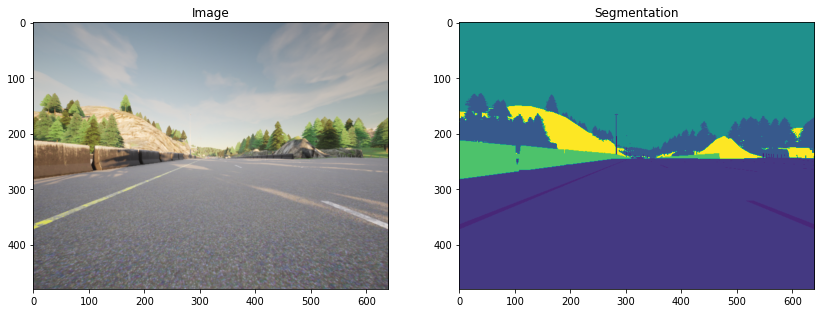

In [3]:
N = 2
img  = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds  = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

Normalmente, se normalizan los valores de la imagen dividiéndolos por `255`. Esto los sitúa entre `0` y `1`. Sin embargo, el uso de `tf.image.convert_image_dtype` con `tf.float32` los sitúa entre `0` y `1`, por lo que no es necesario dividirlos por `255`.

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 

U-Net, llamada así por su forma de U, se creó originalmente en 2015 para la detección de tumores, pero en los años siguientes se ha convertido en una opción muy popular para otras tareas de segmentación semántica. 

La U-Net se basa en una arquitectura anterior denominada red totalmente convolucional (FCN), que sustituye las capas densas de una CNN típica por una capa de convolución transpuesta que remuestrea el mapa de características al tamaño de la imagen de entrada original, conservando la información espacial. Esto es necesario porque las capas densas destruyen la información espacial (el "dónde" de la imagen), que es una parte esencial de las tareas de segmentación de imágenes. Una ventaja añadida de utilizar convoluciones de transposición es que ya no es necesario fijar el tamaño de la entrada, como ocurre cuando se utilizan capas densas. 

Desgraciadamente, la última capa de características de la FCN sufre una pérdida de información debido a un muestreo demasiado reducido. Después de perder tanta información, resulta difícil aumentar el muestreo, lo que hace que el resultado sea tosco. 

U-Net mejora la FCN, utilizando un diseño algo similar, pero difiriendo en algunos aspectos importantes.  En lugar de una convolución transpuesta al final de la red, utiliza un número equivalente de convoluciones para reducir la imagen de entrada a un mapa de características, y convoluciones transpuestas para aumentar esos mapas hasta el tamaño original de la imagen de entrada. También añade conexiones de salto para retener la información que, de otro modo, se perdería durante la codificación. Las conexiones de salto envían información a cada capa de muestreo ascendente en el decodificador desde la capa de muestreo descendente correspondiente en el codificador, lo que permite capturar información más fina y, al mismo tiempo, reducir los cálculos. Esto ayuda a evitar la pérdida de información, así como el sobreajuste del modelo. 

<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Ruta de contracción** (codificador que contiene pasos de reducción de muestreo):

Las imágenes pasan primero por varias capas convolucionales que reducen la altura y la anchura, al tiempo que aumentan el número de canales.

La ruta de contracción sigue una arquitectura normal de CNN, con capas convolucionales, sus activaciones y capas de agrupación para reducir la muestra de la imagen y extraer sus características. En detalle, consiste en la aplicación repetida de dos convoluciones de 3 x 3 sin relleno, cada una de ellas seguida de una unidad lineal rectificada (ReLU) y una operación de pooling de 2 x 2 con stride 2 para el downsampling. En cada paso de muestreo descendente, se duplica el número de canales de características..

**Función de recorte**: Este paso recorta la imagen de la ruta de contratación y la concatena con la imagen actual en la ruta de expansión para crear una conexión de salto. 

**Trayectoria de expansión** (Decodificador que contiene pasos de muestreo ascendente):

La ruta de expansión realiza la operación opuesta a la ruta de contracción, haciendo crecer la imagen hasta su tamaño original, mientras se reducen los canales gradualmente.

En concreto, cada paso de la ruta de expansión aumenta la muestra del mapa de características, seguido de una convolución 2 x 2 (la convolución transpuesta). Esta convolución transpuesta reduce a la mitad el número de canales de características, al tiempo que aumenta la altura y la anchura de la imagen.

A continuación, se realiza una concatenación con el correspondiente mapa de características recortado de la ruta de contratación, y dos convoluciones 3 x 3, cada una de ellas seguida de un ReLU. Es necesario realizar un recorte para manejar la pérdida de píxeles del borde en cada convolución.

**Bloque final de mapeo de características**: En la capa final, se utiliza una convolución 1x1 para mapear cada vector de características de 64 componentes al número deseado de clases. Las dimensiones de los canales de la capa anterior se corresponden con el número de filtros utilizados, por lo que cuando se utilizan convoluciones 1x1, se puede transformar esa dimensión eligiendo un número adecuado de filtros 1x1. Cuando se aplica esta idea a la última capa, se pueden reducir las dimensiones de los canales para tener una capa por clase. 

La red U-Net tiene 23 capas convolucionales en total.

#### Nota importante: 
Las figuras mostradas en la tarea para la arquitectura U-Net representan las dimensiones de las capas y los tamaños de los filtros según el documento original sobre U-Net con imágenes más pequeñas. Sin embargo, debido a las limitaciones computacionales de esta tarea, sólo codificará la mitad de esos filtros. El objetivo de mostrarle las dimensiones originales es darle una idea de la arquitectura original de U-Net. Lo importante es que multiplique por 2 el número de filtros utilizados en el paso anterior. El cuaderno incluye todas las instrucciones y pistas necesarias para ayudarte a codificar la arquitectura U-Net necesaria para esta tarea.

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

El codificador es una pila de varios conv_blocks:

Cada `conv_block()` está compuesto por 2 capas **Conv2D** con activaciones ReLU. Aplicaremos **Dropout**, y **MaxPooling2D** a algunos conv_blocks, como se comprobará en las siguientes secciones, concretamente a los dos últimos bloques del downsampling. 

La función devolverá dos tensores: 
- `siguiente_capa`: Que entrará en el siguiente bloque. 
- `skip_connection`: Que irá al bloque de decodificación correspondiente.

**Nota: Si `max_pooling=True`, la `next_layer` será la salida de la capa MaxPooling2D, pero la `skip_connection` será la salida de la capa aplicada anteriormente (Conv2D o Dropout, según el caso). En caso contrario, ambos resultados serán idénticos.  

<a name='ex-1'></a>
### Exercise 1 - conv_block

Implementar `conv_block(...)`. Aquí están las instrucciones para cada paso en el `conv_block`, o bloque de contratación: 

* Añadir 2 capas **Conv2D** con filtros `n_filters` con `kernel_size` establecido en 3, `kernel_initializer` establecido en ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` establecido en ` same' y ` relu' activación.
* Si `dropout_prob` > 0, entonces añade una capa Dropout con el parámetro `dropout_prob`
* Si `max_pooling` está establecido en True, entonces añade una capa MaxPooling2D con un tamaño de pool de 2x2

In [11]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation         = "relu", #tf.keras.layers.ReLU(),
                  padding            = "same",
                  kernel_initializer = tf.keras.initializers.HeNormal(seed=None)
                 )(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation         = "relu", #tf.keras.layers.ReLU(),,
                  padding            = "same",
                  kernel_initializer = tf.keras.initializers.HeNormal(seed=None)
                 )(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)
    
comparator(summary(model2), output2)

Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]
All tests passed!

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]
All tests passed!


<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

El decodificador, o bloque de muestreo ascendente, vuelve a muestrear las características al tamaño original de la imagen. En cada nivel de remuestreo, tomará la salida del bloque codificador correspondiente y la concatenará antes de alimentar al siguiente bloque decodificador.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

Hay dos componentes nuevos en el descodificador: `up` y `merge`. Son la convolución de transposición y las conexiones de salto. Además, hay dos capas convolucionales más con los mismos parámetros que en el codificador. 

Aquí encontrarás la capa `Conv2DTranspose`, que realiza la inversa de la capa `Conv2D`. Puedes leer más sobre ella [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


<a name='ex-2'></a>
### Exercise 2 - upsampling_block

Implement `upsampling_block(...)`.

Para la función `upsampling_block`: 
* Toma los argumentos `expansive_input` (que es el tensor de entrada de la capa anterior) y `contractive_input` (el tensor de entrada de la capa de salto anterior).
* El número de filtros aquí es el mismo que en el bloque de muestreo descendente que se completó anteriormente
* Tu capa `Conv2DTranspose` tomará `n_filtros` con forma (3,3) y un stride de (2,2), con el padding fijado en `same`. Se aplica a `expansive_input`, o al tensor de entrada de la capa anterior. 

En este bloque también se concatenan las salidas de los bloques codificadores, creando conexiones de salto. 

* Concatena la salida de tu capa Conv2DTranspose a la entrada contractiva, con un `eje` de 3. En general, puedes concatenar los tensores en el orden que prefieras. Pero para el clasificador, es importante que uses `[up, contractive_input]`.

Para el componente final, establezca los parámetros para dos capas Conv2D con los mismos valores que estableció para las dos capas Conv2D en el codificador (activación ReLU, inicializador He normal, `mismo` relleno). 


In [21]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(n_filters,    # number of filters
                 3,                    # Kernel size
                 strides = 2,
                 padding = "same")(expansive_input)
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv  = Conv2D(n_filters,   # Number of filters
                 3,             # Kernel size
                 activation         = "relu",
                 padding            = "same",
                 kernel_initializer = "he_normal")(merge)
    conv  = Conv2D(n_filters,   # Number of filters
                 3,             # Kernel size
                 activation          = "relu",
                 padding             = "same",
                 kernel_initializer  = "he_normal")(conv)
    ### END CODE HERE
    
    return conv

In [22]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

comparator(summary(model1), output1)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']
All tests passed!


<a name='3-4'></a>
### 3.4 - Build the Model

Aquí es donde lo pondrás todo junto, encadenando el codificador, el cuello de botella y el decodificador. Tendrás que especificar el número de canales de salida, que para este conjunto en particular sería 23. Esto se debe a que hay 23 etiquetas posibles para cada píxel en este conjunto de datos de coches autoconducidos. 

<a name='ex-3'></a>
### Exercise 3 - unet_model

Para la función `unet_model`, especifique la forma de entrada, el número de filtros y el número de clases (23 en este caso).

Para la primera mitad del modelo:

* Comienza con un bloque conv que toma las entradas del modelo y el número de filtros
* Luego, encadene el primer elemento de salida de cada bloque a la entrada del siguiente bloque convolucional
* A continuación, duplicar el número de filtros en cada paso
* Comenzando con "conv_block4", agregue "dropout_prob" de 0.3
* Para el último bloque convolucional, vuelva a poner "dropout_prob" a 0,3 y desactive la agrupación máxima.  

Para la segunda mitad:

* Utilice cblock5 como expansive_input y cblock4 como contractive_input, con `n_filters` * 8. Esta es su capa de cuello de botella. 
* Encadena la salida del bloque anterior como expansive_input y la salida del bloque contractivo correspondiente.
* Tenga en cuenta que debe utilizar el segundo elemento del bloque contractivo antes de la capa de agrupación máxima. 
* En cada paso, utilice la mitad del número de filtros del bloque anterior
* `conv9` es una capa Conv2D con activación ReLU, inicializador He normal, relleno `same
* Finalmente, `conv10` es un Conv2D que toma el número de clases como filtro, un tamaño de kernel de 1, y "same" padding. La salida de `conv10` es la salida de su modelo. 

In [32]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Añadir un conv_block con las entradas del modelo unet_ y n_filtros
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Encadena el primer elemento de la salida de cada bloque para que sea la entrada del siguiente conv_block. 
    # Duplicar el número de filtros en cada nuevo paso.
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8,  dropout_prob = 0.3) # Include a dropout_prob of 0.3 for this layer
    # Incluya un dropout_prob de 0,3 para esta capa, y evite la capa max_pooling
    cblock5 = conv_block( cblock4[0], n_filters * 16, dropout_prob = 0.3, max_pooling = False)
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block( cblock5[0], cblock4[1], n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block( ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block( ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block( ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation         = 'relu',
                 padding            = 'same',
                 kernel_initializer = 'he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding = "same")(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [33]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))
comparator(summary(unet), outputs.unet_model_output)


All tests passed!


<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [34]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [35]:
unet.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 96, 128, 32)  896         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_81[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 48, 64, 32)   0           conv2d_82[0][0]                  
______________________________________________________________________________________

<a name='3-6'></a>
### 3.6 - Loss Function

En la segmentación semántica, se necesitan tantas máscaras como clases de objetos. En el conjunto de datos que está utilizando, a cada píxel de cada máscara se le ha asignado una única probabilidad entera de que pertenezca a una determinada clase, de 0 a num_classes-1. La clase correcta es la capa con la mayor probabilidad. 

Esto es diferente de la entropía cruzada categórica, donde las etiquetas deben ser codificadas con un solo número (sólo 0s y 1s). En este caso, se utilizará la entropía cruzada categórica dispersa como función de pérdida, para realizar una predicción multiclase a nivel de píxel. La entropía cruzada categórica dispersa es más eficiente que otras funciones de pérdida cuando se trata de muchas clases.

In [36]:
unet.compile(optimizer = 'adam',
              loss     = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics  = ['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

A continuación, defina una función que le permita mostrar tanto una imagen de entrada como su verdad básica: la máscara verdadera. La máscara verdadera es lo que la salida de su modelo entrenado pretende acercar lo más posible. 

In [37]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


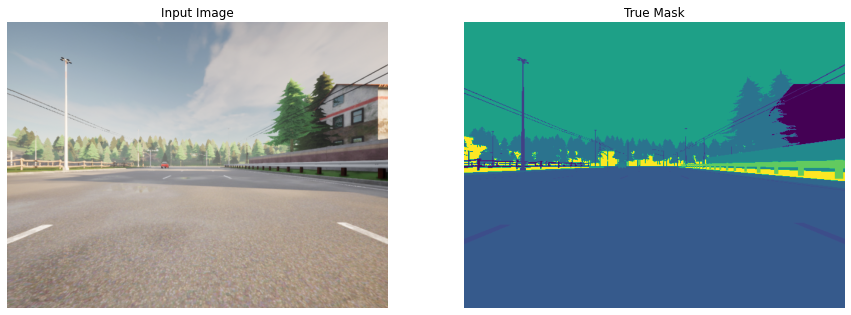

In [38]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


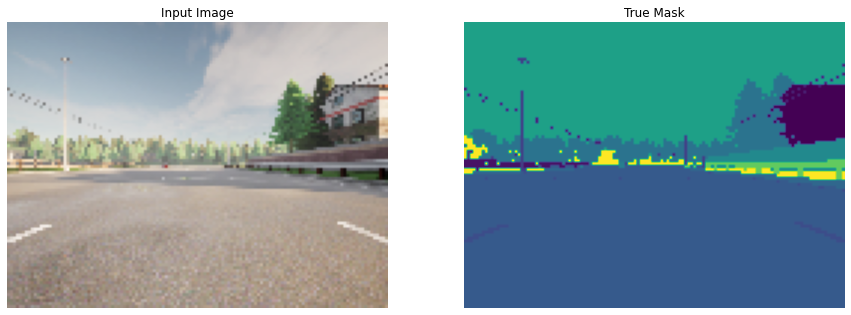

In [39]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [40]:
EPOCHS        = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE   = 500
BATCH_SIZE    = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 19s 572ms/step - loss: 1.7913 - accuracy: 0.4824
Epoch 2/40
34/34 [==============================] - 1s 41ms/step - loss: 0.8087 - accuracy: 0.7853
Epoch 3/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5477 - accuracy: 0.8401
Epoch 4/40
34/34 [==============================] - 1s 40ms/step - loss: 0.4406 - accuracy: 0.8690
Epoch 5/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3855 - accuracy: 0.8853
Epoch 6/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3406 - accuracy: 0.8971
Epoch 7/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3044 - accuracy: 0.9084
Epoch 8/40
34/34 [==============================] - 1s 40ms/step - loss: 0.2623 - accuracy: 0.9211
Epoch 9/40
34/34 [==============================] - 1s 40ms/step - loss: 0.2556 - acc

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Ahora, define una función que utilice `tf.argmax` en el eje del número de clases para devolver el índice con el mayor valor y fusionar la predicción en una sola imagen:

In [41]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

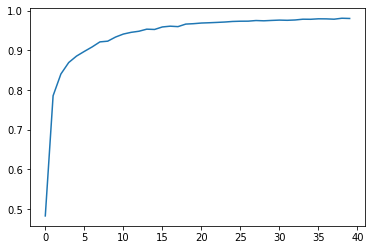

In [42]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [43]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

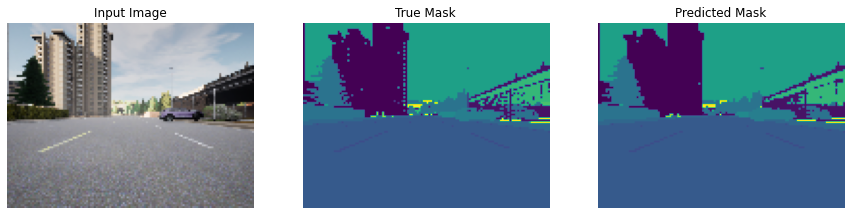

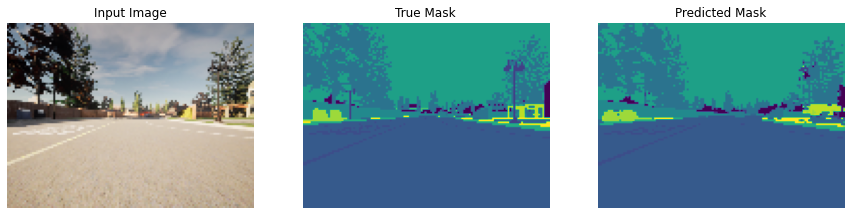

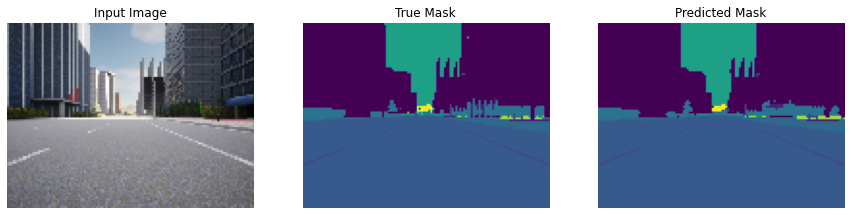

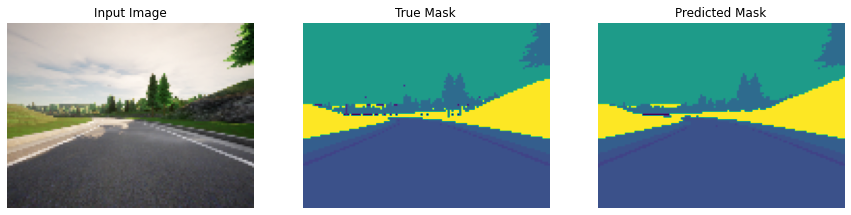

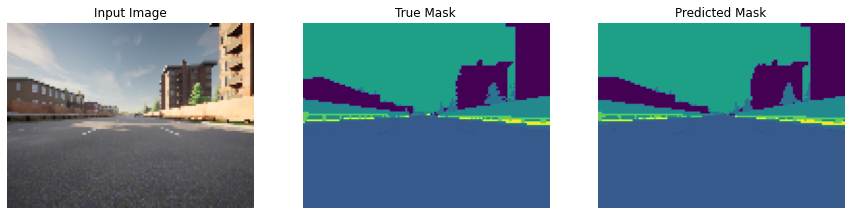

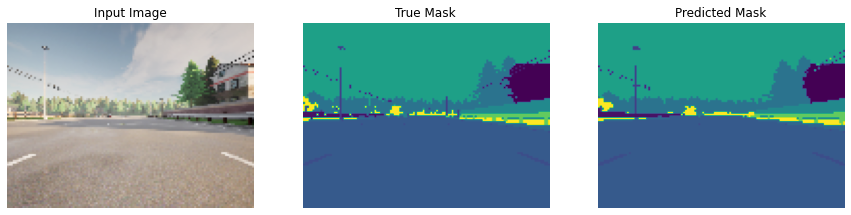

In [44]:
show_predictions(train_dataset, 6)

With 40 epochs you get amazing results!


### Conclusion 

Has llegado al final de esta tarea. Un trabajo impresionante creando un modelo de vanguardia para la segmentación semántica de imágenes. Esta es una tarea muy importante para que los coches de autoconducción lo hagan bien. Seguro que Elon Musk llamará a tu puerta en cualquier momento ;) 

<font color='blue'>
    
**Lo que debes recordar**: 

* La segmentación semántica de la imagen predice una etiqueta para cada píxel de la imagen.
* U-Net utiliza el mismo número de bloques convolucionales y convoluciones transpuestas para el downsampling y el upsampling.
* Las conexiones de omisión se utilizan para evitar la pérdida de información de los píxeles del borde y el sobreajuste en U-Net.